# Post-processing for 2030StateScenario


## Packages

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import pickle
import seaborn as sns

import nygrid.run_nygrid as ng_run
import nygrid.nygrid as ng_grid
import nygrid.postprocessing as ng_post

In [2]:
# Set up directories
cwd = os.getcwd()
if 'examples' in cwd:
    parent_dir = os.path.dirname(cwd)
    data_dir = os.path.join(parent_dir, 'data')
else:
    data_dir = os.path.join(cwd, 'data')

fig_dir = os.path.join(os.path.dirname(data_dir), 'figures')
print('Figure directory: {}'.format(fig_dir))

results_dir = os.path.join(os.path.dirname(data_dir), 'results')
print('Results directory: {}'.format(results_dir))


Figure directory: /mnt/Bo_HDD/NYgrid-python/figures
Results directory: /mnt/Bo_HDD/NYgrid-python/results


## Read grid data

In [3]:
# Cost modifiers
ext_cost_factor = 0.0
# fo_cost_factor = 1.0
fo_cost_factor = 0.5

# Simulation time settings
valid_days = 14
lookahead_days = 2

valid_hours = 24 * valid_days
lookahead_hours = 24 * lookahead_days

sim_start_time = datetime(2018, 1, 1, 0, 0, 0)
sim_end_time = datetime(2018, 12, 31, 23, 0, 0)
timestamp_list = pd.date_range(sim_start_time, sim_end_time, freq=f'{valid_days}D')


## Read OPF results

In [4]:
sim_name = f'2030StateScenario_FewerOSW_ext{ext_cost_factor}_fo{fo_cost_factor}_daily'

grid_data_dir_2030 = os.path.join(data_dir, 'grid', '2030StateScenario_FewerOSW')
assert os.path.exists(
    grid_data_dir_2030), f'Grid data directory not found: {grid_data_dir_2030}'

sim_results_dir_2030 = os.path.join(results_dir, sim_name)
assert os.path.exists(
    sim_results_dir_2030), f'Results directory not found: {sim_results_dir_2030}'

# Read load and generation profiles
grid_prop_2030 = ng_run.read_grid_prop(grid_data_dir_2030,
                                       if_lims_prop_file='if_lims_prop_2030StateScenario.csv',
                                       esr_prop_file='esr_prop_2030StateScenario.csv',
                                       dcline_prop_file='dcline_prop_2030StateScenario.csv')
display(grid_prop_2030.keys())

grid_profile_2030 = ng_run.read_grid_profile(grid_data_dir_2030, year=2030)
display(grid_profile_2030.keys())

# Generator fuel types
display(grid_prop_2030['gen_fuel']['GEN_FUEL'].unique())

# Create NYGrid object
start_datetime_0 = timestamp_list[0]
end_datetime_0 = start_datetime_0 + timedelta(hours=23)
nygrid_sim_2030 = ng_grid.NYGrid(grid_prop=grid_prop_2030,
                                 start_datetime=start_datetime_0,
                                 end_datetime=end_datetime_0,
                                 verbose=False)
print(f"Number of generators: {nygrid_sim_2030.NG}")
print(f"Number of HVDC lines: {nygrid_sim_2030.NDCL}")
print(f"Number of VRE generators: {nygrid_sim_2030.NVRE}")
print(f"Number of ESR units: {nygrid_sim_2030.NESR}")
print(
    f"Number of buses and branches: {nygrid_sim_2030.NB} and {nygrid_sim_2030.NBR}")
print(f"Number of loads: {nygrid_sim_2030.NL}")
print(f"Number of time periods: {nygrid_sim_2030.NT}")

dict_keys(['bus_prop', 'gen_prop', 'gen_fuel', 'gencost_prop', 'branch_prop', 'if_lim_prop', 'if_map_prop', 'esr_prop', 'dcline_prop'])

dict_keys(['load_profile', 'genmax_profile', 'genmin_profile', 'gencost0_profile', 'gencost1_profile', 'gencost_startup_profile'])

array(['CT_NG', 'CC_NG', 'CT_FO2', 'CT_KER', 'ST_NG', 'ST_FO6', 'NU_UR',
       'HY_WAT', 'Import_Import', 'WT_WND', 'PV_SUN', 'Other_Other',
       'Load_Load'], dtype=object)

Number of generators: 465
Number of HVDC lines: 6
Number of VRE generators: 0
Number of ESR units: 40
Number of buses and branches: 57 and 97
Number of loads: 57
Number of time periods: 24


In [5]:
# Loop through all days
results_list_2030 = []

for d in range(len(timestamp_list)):
    
    # Set clycle start and end datetime
    cycle_start_time = timestamp_list[d]

    # Read results
    filename = f'nygrid_sim_{sim_name}_{cycle_start_time.strftime("%Y%m%d")}_{valid_days}_{lookahead_days}.pkl'
    with open(os.path.join(sim_results_dir_2030, filename), 'rb') as f:
        results = pickle.load(f)

    results_list_2030.append(results)

In [6]:
# Power dispatch of generators by fuel type
# Including ESR, DC line, and VRE
pg_by_fuel_dict_2030 = ng_post.get_pg_by_fuel_from_list(results_list_2030, 
                                                        nygrid_sim_2030,
                                                        valid_hours=valid_hours)

# ESR results, including discharge and charge power, and SOC
esr_results_2030 = ng_post.get_esr_results_from_list(results_list_2030, 
                                                     nygrid_sim_2030,
                                                     valid_hours=valid_hours)

# LMP by bus and by zone
# lmp_results_2018 = ng_post.get_lmp_results_from_list(results_list_2018, 
#                                                      nygrid_sim_2018,
#                                                      valid_hours=24)

# Branch flow and interface flow results
flow_results_2030 = ng_post.get_flow_results_from_list(results_list_2030, 
                                                       nygrid_sim_2030,
                                                       valid_hours=valid_hours)

# Costs
cost_results_2030 = ng_post.get_cost_results_from_list(results_list_2030, 
                                                       nygrid_sim_2030,
                                                       valid_hours=valid_hours)

# Slack variables and penalty costs
slack_results_2030 = ng_post.get_slack_results_from_list(results_list_2030, 
                                                         nygrid_sim_2030,
                                                         valid_hours=valid_hours)

## Calculate heat input

In [7]:
# 2018 NYCA: 181 thermal generators
thermal_params_2030 = pd.read_csv(os.path.join(
    grid_data_dir_2030, 'thermal_params.csv'))
thermal_params_2030['GEN_NAME'] = thermal_params_2030['NYISO_Name']+thermal_params_2030['ID']

In [8]:
# Save thermal generation profiles for emissions calculation
thermal_fuel_types = ['CC_NG', 'CT_NG', 'CT_FO2', 'CT_KER', 'ST_NG', 'ST_FO6']
thermal_pg_list_2030 = [pg_by_fuel_dict_2030[fuel] for fuel in thermal_fuel_types]
thermal_pg_2030StateScenario = pd.concat(thermal_pg_list_2030, axis=1)
thermal_pg_2030StateScenario = thermal_pg_2030StateScenario.sort_index(axis=1)

# Order the columns
thermal_pg_2030StateScenario = thermal_pg_2030StateScenario[thermal_params_2030['GEN_NAME']]

# Save to csv
thermal_pg_2030StateScenario.to_csv(os.path.join(results_dir, sim_name,
                                            f'thermal_pg_{sim_name}.csv'))

# Calculate heat input from power generation
heat_input_2030StateScenario = ng_post.thermal_pg_2_heat_input(thermal_pg_2030StateScenario, 
                                                          thermal_params_2030)

# Order the columns
heat_input_2030StateScenario = heat_input_2030StateScenario[thermal_params_2030['GEN_NAME']]

# Save to csv
heat_input_2030StateScenario.to_csv(os.path.join(results_dir, sim_name,
                                            f'heat_input_{sim_name}.csv'))

In [9]:
# Create a dictionary for generator to bus mapping
gen_2bus = grid_prop_2030['gen_prop'][['GEN_NAME','GEN_BUS']].copy()
gen_2bus['GEN_BUS'] = gen_2bus['GEN_BUS'].astype(int)
gen_2bus_dict = dict(zip(gen_2bus['GEN_NAME'], gen_2bus['GEN_BUS']))

# Large load time series
large_load = pg_by_fuel_dict_2030['Load_Load']
large_load_2bus = large_load.copy().T.groupby(gen_2bus_dict).sum().T
# Convert negative generation to positive load
large_load_2bus = -large_load_2bus

# Add large load to load profile
load_profile_2030StateScenario = grid_profile_2030['load_profile'].copy()
load_profile_2030StateScenario = load_profile_2030StateScenario.add(large_load_2bus, fill_value=0)

# Save load profile for emissions calculation
load_profile_2030StateScenario.to_csv(os.path.join(results_dir, sim_name,
                                              f'load_profile_{sim_name}.csv'))

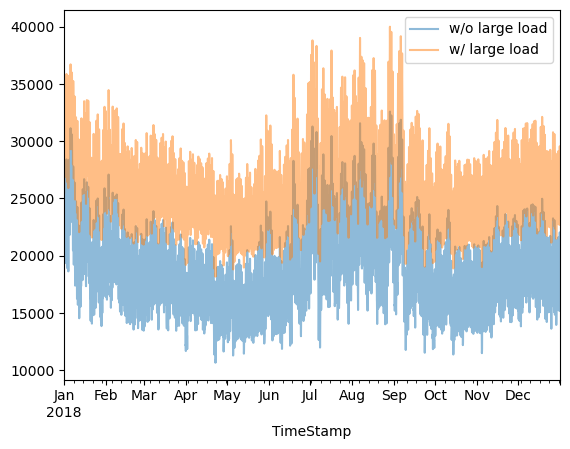

In [10]:
grid_profile_2030['load_profile'].sum(axis=1).plot(label='w/o large load', alpha=0.5)
load_profile_2030StateScenario.sum(axis=1).plot(label='w/ large load', alpha=0.5)
plt.legend()

## Plotting

In [11]:
if not os.path.exists(os.path.join(fig_dir, 'thermal_pg')):
    os.makedirs(os.path.join(fig_dir, 'thermal_pg'))


In [12]:
# Representative weeks
season_list = ['Winter', 'Spring', 'Summer', 'Autumn']

winter_week = ['2018-01-01', '2018-01-07']
spring_week = ['2018-04-02', '2018-04-08']
summer_week = ['2018-07-02', '2018-07-08']
autumn_week = ['2018-10-01', '2018-10-07']

week_list = [winter_week, spring_week, summer_week, autumn_week]

zone_order = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K',
              'NE', 'PJM', 'IESO', 'HQ']

In [13]:
# Change HQ import zone from 'D' and 'J' to 'HQ'
gen_prop = grid_prop_2030['gen_prop'].copy()
hq_idx = gen_prop[(gen_prop['GEN_ZONE'].isin(['D','J'])) & (gen_prop['UNIT_TYPE'] == 'Import')].index
gen_prop.loc[hq_idx, 'GEN_ZONE'] = 'HQ'

gen2zone_dict = gen_prop.set_index('GEN_NAME')[
    'GEN_ZONE'].to_dict()
esr2zone_dict = grid_prop_2030['esr_prop'].set_index('ESR_NAME')[
    'ESR_ZONE'].to_dict()
dclinef2zone_dict = grid_prop_2030['dcline_prop'].set_index('DC_NAME')[
    'FROM_ZONE'].to_dict()
dclinet2zone_dict = grid_prop_2030['dcline_prop'].set_index('DC_NAME')[
    'TO_ZONE'].to_dict()

In [14]:
gen_fuel_rename = {
    'NU_UR': 'Nuclear',
    'CC_NG': 'Combined Cycle (NG)',
    'ST_BIT': 'Steam Turbine (BIT)', 
    'ST_FO6': 'Steam Turbine (FO6)',
    'ST_NG': 'Steam Turbine (NG)',
    'CT_FO2': 'Combustion Turbine (FO2)',
    'CT_KER': 'Combustion Turbine (KER)',
    'CT_NG': 'Combustion Turbine (NG)',
    'Other_Other': 'Other',
    'Import_Import': 'Import (or Export)',
    'DCLine_F': 'DC Line (From)',
    'DCLine_T': 'DC Line (To)',
    'HY_WAT': 'Hydro',
    'PSH': 'Pumped Hydro Storage',
    'PV_SUN': 'Utility-scale PV',
    'LBW': 'Land-based Wind',
    'OSW': 'Offshore Wind',
    'BES': 'Battery Storage',
}

# Pumped hydro storage units
phs_names = [
    'Gilboa 1 (IIFO - 1/1/2019)', 'Gilboa 2', 
    'Gilboa 3', 'Gilboa 4', 'Lewiston PS'
]

# Offshore wind units
osw_names = [
    'Attentive Energy', 'Beacon Wind', 
    'Community Offshore Wind', 'Empire Offshore Wind',
    'Mid-Atlantic Offshore Wind', 'Sunrise Wind'
]

In [15]:
# Separate PSH and ESR units
pg_by_fuel_dict_2030['PSH'] = pg_by_fuel_dict_2030['ESR'][phs_names].copy()

pg_by_fuel_dict_2030['BES'] = pg_by_fuel_dict_2030['ESR'].copy()
pg_by_fuel_dict_2030['BES'] = pg_by_fuel_dict_2030['BES'].drop(columns=phs_names)

# Separate LBW and OSW units
# This scenario does not have OSW units
pg_by_fuel_dict_2030['LBW'] = pg_by_fuel_dict_2030['WT_WND'].copy()
pg_by_fuel_dict_2030['OSW'] = pg_by_fuel_dict_2030['WT_WND'].copy()
pg_by_fuel_dict_2030['OSW'] = pg_by_fuel_dict_2030['OSW'].drop(columns=pg_by_fuel_dict_2030['LBW'].columns)

# Add ST_BIT placeholder (All coal units have been retired)
pg_by_fuel_dict_2030['ST_BIT'] = pg_by_fuel_dict_2030['CC_NG'].drop(columns=pg_by_fuel_dict_2030['CC_NG'].columns)


### 1. Power generation by fuel type

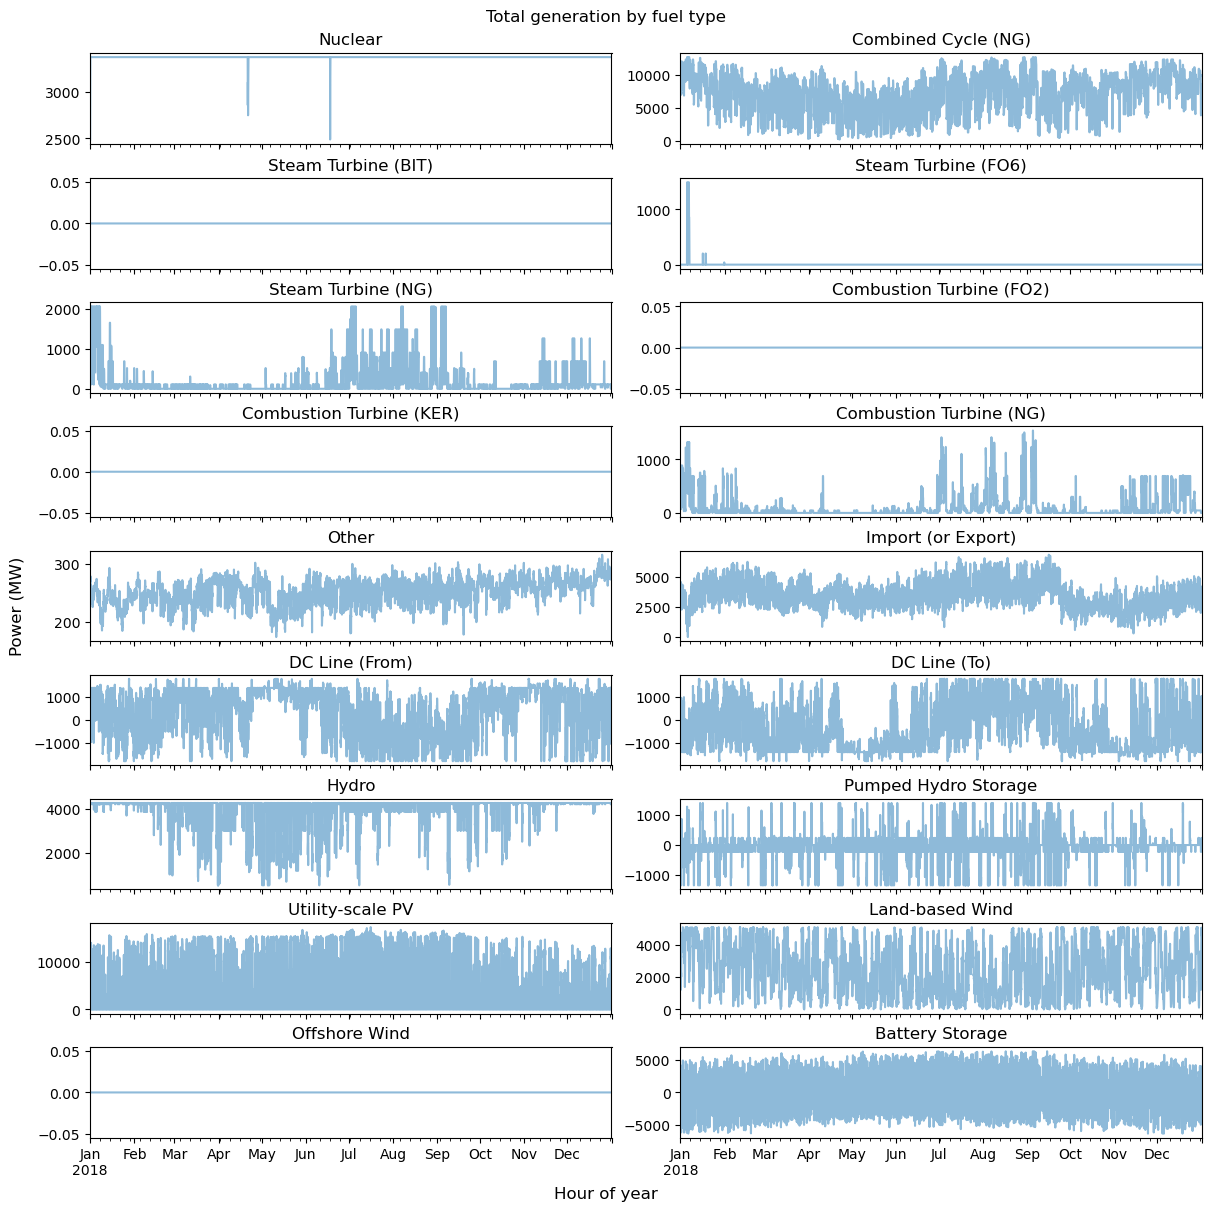

In [16]:
pg_by_fuel_sum = dict()

for fuel_type, pg_by_fuel in pg_by_fuel_dict_2030.items():
    pg_by_fuel_sum[fuel_type] = pg_by_fuel.sum(axis=1)

# Convert to DataFrame
pg_by_fuel_sum = pd.DataFrame(pg_by_fuel_sum,
                              index=pg_by_fuel_dict_2030['CC_NG'].index)

# Rename columns
pg_by_fuel_sum = pg_by_fuel_sum.rename(columns=gen_fuel_rename)

# Reorder columns
pg_by_fuel_sum = pg_by_fuel_sum[gen_fuel_rename.values()]

fig, axs = plt.subplots(pg_by_fuel_sum.shape[1]//2, 2, figsize=(12, 12),
                        layout='constrained', sharex=True)

for i, fuel_type in enumerate(pg_by_fuel_sum.columns):
    ax = axs.flatten()[i]
    pg_by_fuel_sum[fuel_type].plot(ax=ax, alpha=0.5, color='tab:blue')

    ax.set_title(fuel_type)

fig.supxlabel('Hour of year')
fig.supylabel('Power (MW)')
fig.suptitle('Total generation by fuel type')
plt.show()

In [17]:
pg_by_fuel_sum_by_zone = dict()

for fuel_type, pg_by_fuel in pg_by_fuel_dict_2030.items():
    if fuel_type == 'DCLine_F':
        pg_by_fuel_by_zone = pg_by_fuel.groupby(
            [dclinef2zone_dict], axis=1).sum().sum().to_dict()
    elif fuel_type == 'DCLine_T':
        pg_by_fuel_by_zone = pg_by_fuel.groupby(
            [dclinet2zone_dict], axis=1).sum().sum().to_dict()
    elif fuel_type == 'ESR':
        pg_by_fuel_by_zone = pg_by_fuel.groupby(
            [esr2zone_dict], axis=1).sum().sum().to_dict()
    else:
        pg_by_fuel_by_zone = pg_by_fuel.groupby(
            [gen2zone_dict], axis=1).sum().sum().to_dict()
    pg_by_fuel_sum_by_zone[fuel_type] = pg_by_fuel_by_zone
    
pg_by_fuel_sum_by_zone = pd.DataFrame(pg_by_fuel_sum_by_zone)

# Add zone I
if 'I' not in pg_by_fuel_sum_by_zone.index:
    pg_by_fuel_sum_by_zone.loc['I'] = np.nan

# Rename columns
pg_by_fuel_sum_by_zone = pg_by_fuel_sum_by_zone.rename(columns=gen_fuel_rename)

pg_by_fuel_sum_by_zone = pg_by_fuel_sum_by_zone[gen_fuel_rename.values()]

pg_by_fuel_sum_by_zone = pg_by_fuel_sum_by_zone/1e6 # Convert to TWh

pg_by_fuel_sum_by_zone = pg_by_fuel_sum_by_zone.T[zone_order].T

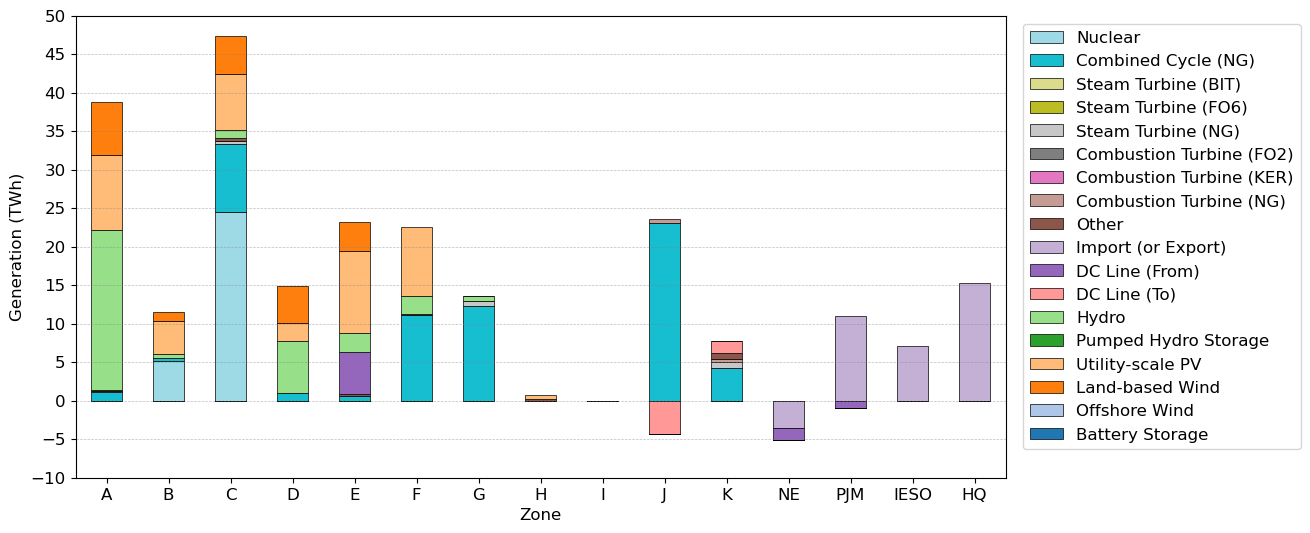

In [18]:
fig, ax = plt.subplots(figsize=(12, 6))
pg_by_fuel_sum_by_zone.plot(ax=ax, kind='bar', stacked=True, figsize=(12, 6),
                            colormap='tab20_r', edgecolor='black', linewidth=0.5)
ax.set_xlabel('Zone', fontsize=12)
ax.set_ylabel('Generation (TWh)', fontsize=12)
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left',
          fontsize=12)
ax.tick_params(axis='x', rotation=0)
ax.tick_params(axis='both', labelsize=12)
ax.set_ylim(-10, 50)
ax.set_yticks(np.arange(-10, 51, 5))
ax.grid(axis='y', color='gray', lw=0.5, ls='--', alpha=0.5)
plt.show()

In [19]:
# Group by generator type and month
pg_by_fuel_sum_by_month = dict()

for fuel_type, pg_by_fuel in pg_by_fuel_dict_2030.items():
    pg_by_fuel_by_month = pg_by_fuel.groupby(pg_by_fuel.index.month).sum().sum(axis=1).to_dict()
    pg_by_fuel_sum_by_month[fuel_type] = pg_by_fuel_by_month
    
pg_by_fuel_sum_by_month = pd.DataFrame(pg_by_fuel_sum_by_month)

# Rename columns
pg_by_fuel_sum_by_month = pg_by_fuel_sum_by_month.rename(columns=gen_fuel_rename)

pg_by_fuel_sum_by_month = pg_by_fuel_sum_by_month[gen_fuel_rename.values()]

pg_by_fuel_sum_by_month = pg_by_fuel_sum_by_month/1e6 # Convert to TWh


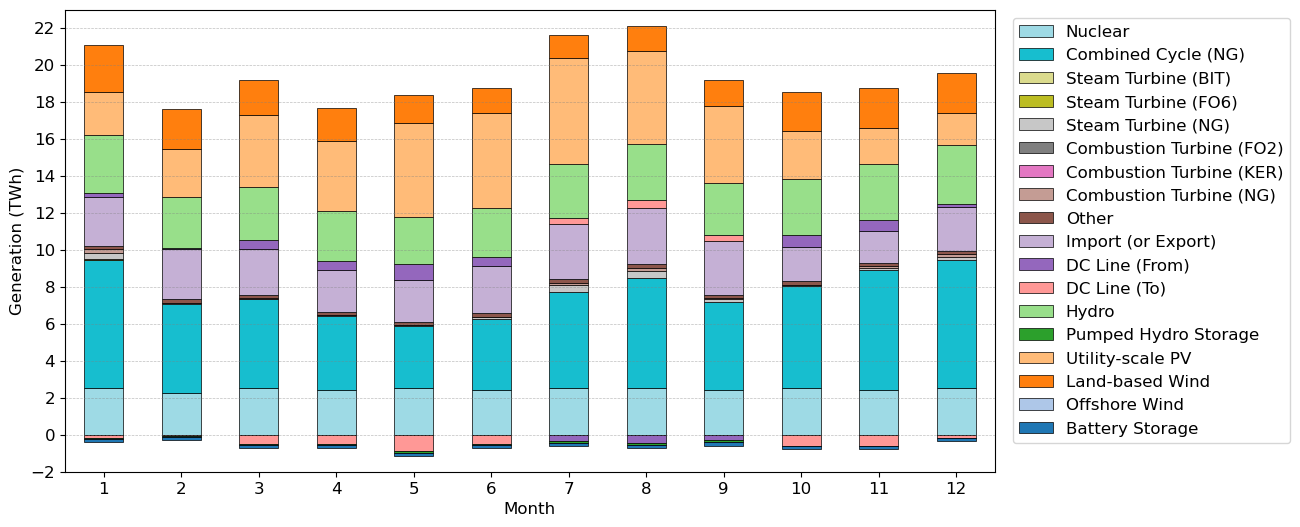

In [20]:
fig, ax = plt.subplots(figsize=(12, 6))
pg_by_fuel_sum_by_month.plot(ax=ax, kind='bar', stacked=True, figsize=(12, 6),
                            colormap='tab20_r', edgecolor='black', linewidth=0.5)
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Generation (TWh)', fontsize=12)
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left',
          fontsize=12)
ax.tick_params(axis='x', rotation=0)
ax.tick_params(axis='both', labelsize=12)
ax.set_ylim(-2, 23)
ax.set_yticks(np.arange(-2, 23, 2))
ax.grid(axis='y', color='gray', lw=0.5, ls='--', alpha=0.5)
plt.show()

### 2. Check renewable curtailment

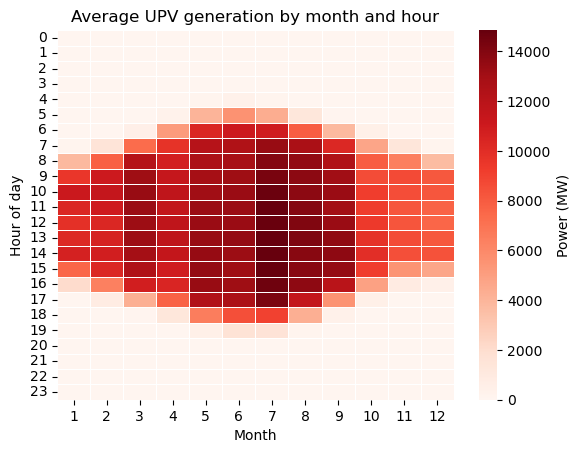

In [21]:
upv_gen = pg_by_fuel_dict_2030['PV_SUN'].sum(axis=1)
upv_gen_by_month_hour = upv_gen.groupby([upv_gen.index.month, upv_gen.index.hour]).mean()
upv_gen_by_month_hour = upv_gen_by_month_hour.unstack(level=0)

sns.heatmap(upv_gen_by_month_hour, cmap='Reds', cbar_kws={'label': 'Power (MW)'},
            linewidths=0.5, linecolor='white')
plt.xlabel('Month')
plt.ylabel('Hour of day')
plt.title('Average UPV generation by month and hour')
plt.show()

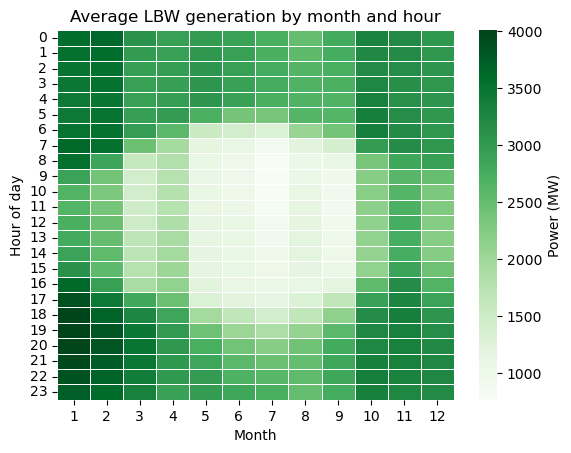

In [22]:
lbw_gen = pg_by_fuel_dict_2030['LBW'].sum(axis=1)
lbw_gen_by_month_hour = lbw_gen.groupby([lbw_gen.index.month, lbw_gen.index.hour]).mean()
lbw_gen_by_month_hour = lbw_gen_by_month_hour.unstack(level=0)

sns.heatmap(lbw_gen_by_month_hour, cmap='Greens', cbar_kws={'label': 'Power (MW)'},
            linewidths=0.5, linecolor='white')
plt.xlabel('Month')
plt.ylabel('Hour of day')
plt.title('Average LBW generation by month and hour')
plt.show()

In [41]:
# UPV curtailment
# Maximum available UPV generation
upv_index = grid_prop_2030["gen_fuel"]["GEN_FUEL"].isin(["PV_SUN"]).to_numpy()
upv_genmax_profile = grid_profile_2030['genmax_profile'].loc[:, upv_index]

# Aggregate UPV available generation by zone
upv_genmax_zone = upv_genmax_profile.groupby(
    [gen2zone_dict], axis=1).sum()

# Aggregate by month
upv_genmax_zone_month = upv_genmax_zone.groupby(
    upv_genmax_zone.index.month).sum()

# Calculate UPV curtailment
upv_curtailment = upv_genmax_profile - pg_by_fuel_dict_2030['PV_SUN']

# Remove negative curtailment
upv_curtailment[upv_curtailment < 0] = 0

# Aggregate UPV curtailment by zone
upv_curtailment_zone = upv_curtailment.groupby(
    [gen2zone_dict], axis=1).sum()

# Aggregate by month
upv_curtailment_zone_month = upv_curtailment_zone.groupby(
    upv_curtailment_zone.index.month).sum()

# Calculate curtailment percentage
upv_curtailment_pct_zone_month = upv_curtailment_zone_month / upv_genmax_zone_month * 100

# Convert to GWh
upv_curtailment_zone_month = upv_curtailment_zone_month / 1e3

# Add missing zones
for zone in zone_order[:11]:
    if zone not in upv_curtailment_zone_month.columns:
        upv_curtailment_zone_month[zone] = np.nan
        upv_curtailment_pct_zone_month[zone] = np.nan

# Reorder columns
upv_curtailment_zone_month = upv_curtailment_zone_month[zone_order[:11]]
upv_curtailment_pct_zone_month = upv_curtailment_pct_zone_month[zone_order[:11]]


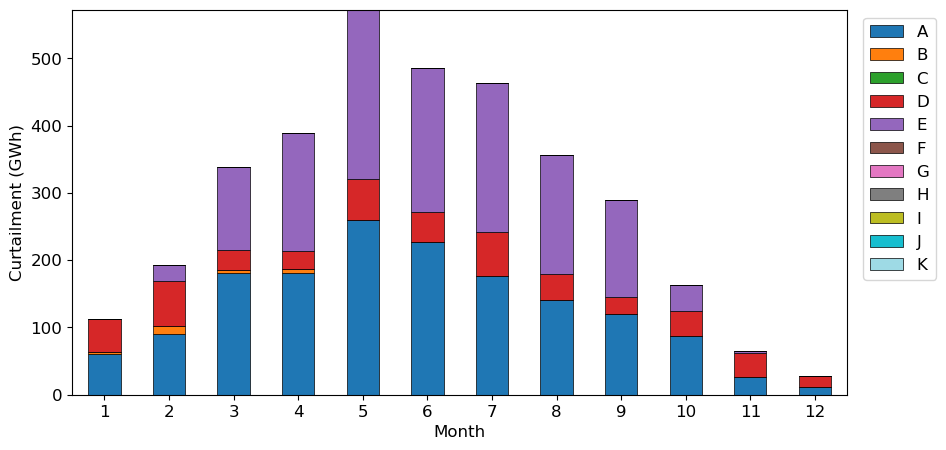

In [42]:
# Plot UPV curtailment
fig, ax = plt.subplots(figsize=(12, 6))
upv_curtailment_zone_month.plot(ax=ax, kind='bar', stacked=True, figsize=(10, 5),
                           colormap='tab20', edgecolor='black', linewidth=0.5)
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Curtailment (GWh)', fontsize=12)
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left',
          fontsize=12)
ax.tick_params(axis='x', rotation=0)
ax.tick_params(axis='both', labelsize=12)
ax.axhline(0, color='black', lw=0.5, ls='--')
# ax.set_ylim(-1, 20)
plt.show()

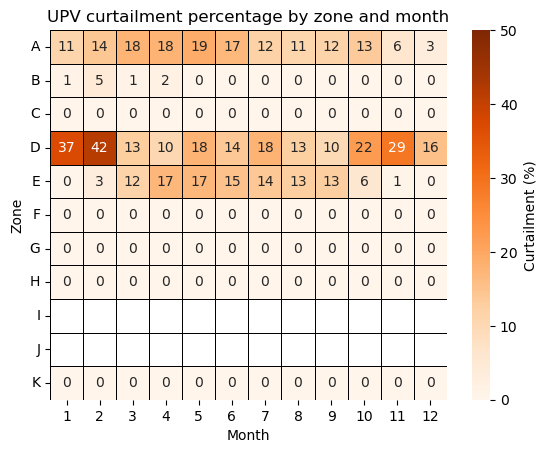

In [43]:
sns.heatmap(upv_curtailment_pct_zone_month.T, cmap='Oranges', cbar_kws={'label': 'Curtailment (%)'},
            linewidths=0.5, linecolor='black',
            mask=upv_curtailment_pct_zone_month.T.isnull(),
            annot=True, fmt=".0f",
            vmax=50, vmin=0)
plt.xlabel('Month')
plt.ylabel('Zone')
plt.tick_params(axis='y', rotation=0)
plt.title('UPV curtailment percentage by zone and month')
plt.show()

In [44]:
# Wind curtailment
wind_index = grid_prop_2030["gen_fuel"]["GEN_FUEL"].isin(["WT_WND"]).to_numpy()
wind_genmax_profile = grid_profile_2030['genmax_profile'].loc[:, wind_index]

# Aggregate wind available generation by zone
wind_genmax_zone = wind_genmax_profile.groupby(
    [gen2zone_dict], axis=1).sum()

# Aggregate by month
wind_genmax_zone_month = wind_genmax_zone.groupby(
    wind_genmax_zone.index.month).sum()

# Calculate wind curtailment
wind_curtailment = wind_genmax_profile - pg_by_fuel_dict_2030['WT_WND']

# Remove negative curtailment
wind_curtailment[wind_curtailment < 0] = 0

# Aggregate by zone
wind_curtailment_zone = wind_curtailment.T.groupby(gen2zone_dict).sum().T

# Aggregate by month
wind_curtailment_zone_month = wind_curtailment_zone.groupby(
    wind_curtailment_zone.index.month).sum()

# Calculate curtailment percentage
wind_curtailment_pct_zone_month = wind_curtailment_zone_month / wind_genmax_zone_month * 100

# Convert to GWh
wind_curtailment_zone_month = wind_curtailment_zone_month/1e3

# Add missing zones
for zone in zone_order[:11]:
    if zone not in wind_curtailment_zone_month.columns:
        wind_curtailment_zone_month[zone] = np.nan
        wind_curtailment_pct_zone_month[zone] = np.nan

# Reorder columns
wind_curtailment_zone_month = wind_curtailment_zone_month[zone_order[:11]]
wind_curtailment_pct_zone_month = wind_curtailment_pct_zone_month[zone_order[:11]]


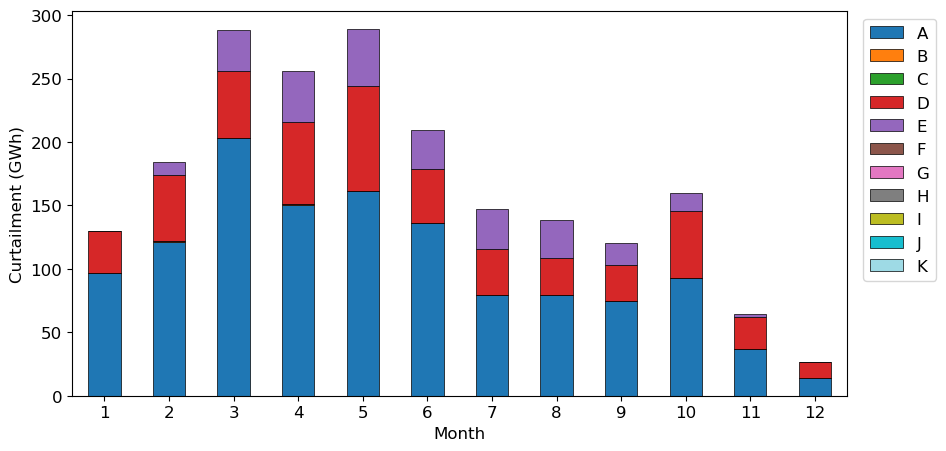

In [45]:
# Plot Wind curtailment
fig, ax = plt.subplots(figsize=(12, 6))
wind_curtailment_zone_month.plot(ax=ax, kind='bar', stacked=True, figsize=(10, 5),
                                 colormap='tab20', edgecolor='black', linewidth=0.5)
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Curtailment (GWh)', fontsize=12)
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left',
          fontsize=12)
ax.tick_params(axis='x', rotation=0)
ax.tick_params(axis='both', labelsize=12)
ax.axhline(0, color='black', lw=0.5, ls='--')
# ax.set_ylim(-1, 20)
plt.show()

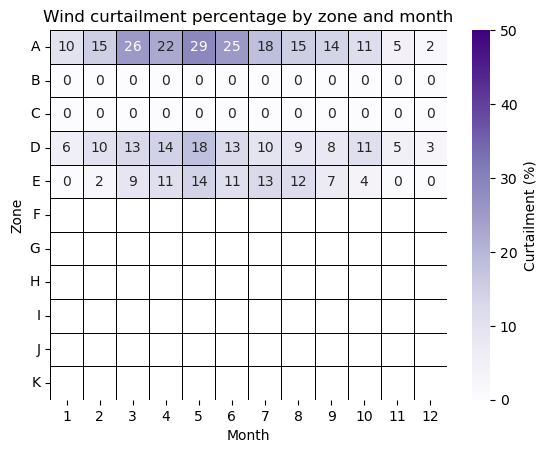

In [46]:
sns.heatmap(wind_curtailment_pct_zone_month.T, cmap='Purples', cbar_kws={'label': 'Curtailment (%)'},
            linewidths=0.5, linecolor='black',
            mask=wind_curtailment_pct_zone_month.T.isnull(),
            annot=True, fmt=".0f",
            vmax=50, vmin=0)
plt.xlabel('Month')
plt.ylabel('Zone')
plt.tick_params(axis='y', rotation=0)
plt.title('Wind curtailment percentage by zone and month')
plt.show()

In [47]:
# Large Load curtailment (as negative generation)
load_index = grid_prop_2030["gen_fuel"]["GEN_FUEL"].isin(["Load_Load"]).to_numpy()
load_genmax_profile = grid_profile_2030['genmin_profile'].loc[:, load_index] * -1

# Aggregate load available generation by zone
load_genmax_zone = load_genmax_profile.groupby(
    [gen2zone_dict], axis=1).sum()

# Aggregate by month
load_genmax_zone_month = load_genmax_zone.groupby(
    load_genmax_zone.index.month).sum()

# Calculate load curtailment
load_curtailment = load_genmax_profile - pg_by_fuel_dict_2030['Load_Load'] * -1

# Remove negative curtailment
load_curtailment[load_curtailment < 0] = 0

# Aggregate by zone
load_curtailment_zone = load_curtailment.T.groupby(gen2zone_dict).sum().T

# Aggregate by month
load_curtailment_zone_month = load_curtailment_zone.groupby(
    load_curtailment_zone.index.month).sum()

# Calculate curtailment percentage
load_curtailment_pct_zone_month = load_curtailment_zone_month / load_genmax_zone_month * 100

# Convert to GWh
load_curtailment_zone_month = load_curtailment_zone_month/1e3

# Add missing zones
for zone in zone_order[:11]:
    if zone not in load_curtailment_zone_month.columns:
        load_curtailment_zone_month[zone] = np.nan
        load_curtailment_pct_zone_month[zone] = np.nan

# Reorder columns
load_curtailment_zone_month = load_curtailment_zone_month[zone_order[:11]]
load_curtailment_pct_zone_month = load_curtailment_pct_zone_month[zone_order[:11]]

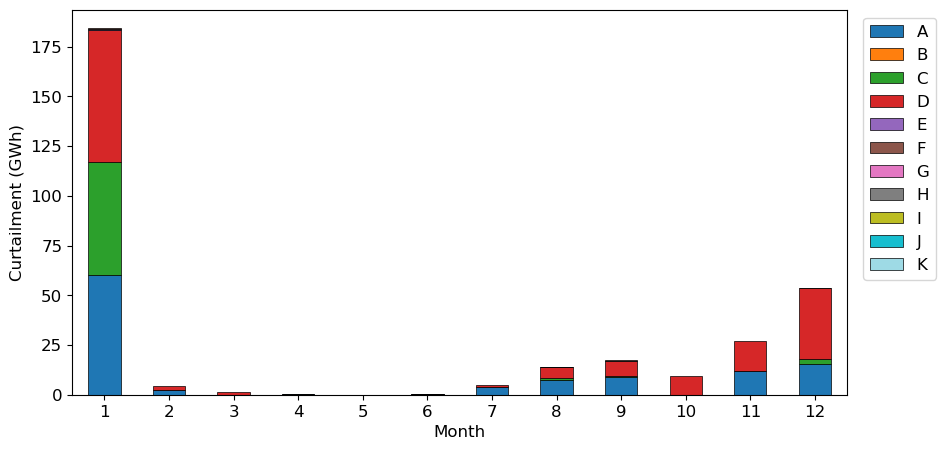

In [48]:
# Plot large load curtailment
fig, ax = plt.subplots(figsize=(12, 6))
load_curtailment_zone_month.plot(ax=ax, kind='bar', stacked=True, figsize=(10, 5),
                                 colormap='tab20', edgecolor='black', linewidth=0.5)
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Curtailment (GWh)', fontsize=12)
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left',
          fontsize=12)
ax.tick_params(axis='x', rotation=0)
ax.tick_params(axis='both', labelsize=12)
ax.axhline(0, color='black', lw=0.5, ls='--')
# ax.set_ylim(-1, 20)
plt.show()

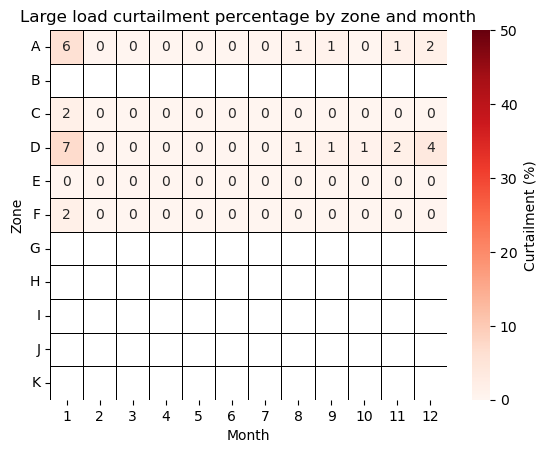

In [49]:
sns.heatmap(load_curtailment_pct_zone_month.T, cmap='Reds', cbar_kws={'label': 'Curtailment (%)'},
            linewidths=0.5, linecolor='black', 
            mask=load_curtailment_pct_zone_month.T.isnull(),
            annot=True, fmt=".0f",
            vmax=50, vmin=0)
plt.xlabel('Month')
plt.ylabel('Zone')
plt.tick_params(axis='y', rotation=0)
plt.title('Large load curtailment percentage by zone and month')
plt.show()

### 3. Check external generation and load

In [32]:
# External generator maximum generation profile
genmax_profile = grid_profile_2030['genmax_profile']

ne_cols = [col for col in genmax_profile.columns if 'NE' in col]
pjm_cols = [col for col in genmax_profile.columns if 'PJM' in col]
ieso_cols = [col for col in genmax_profile.columns if 'IESO' in col]
hq_cols = [col for col in genmax_profile.columns if 'HQ' in col]
genmax_ne_sum = genmax_profile[ne_cols].sum(axis=1)
genmax_pjm_sum = genmax_profile[pjm_cols].sum(axis=1)
genmax_ieso_sum = genmax_profile[ieso_cols].sum(axis=1)
genmax_hq_sum = genmax_profile[hq_cols].sum(axis=1)

genmax_profile_external_sum = genmax_ne_sum + genmax_pjm_sum \
    + genmax_ieso_sum + genmax_hq_sum

In [33]:
# External generator minimum generation profile
genmin_profile = grid_profile_2030['genmin_profile']

ne_cols = [col for col in genmin_profile.columns if 'NE' in col]
pjm_cols = [col for col in genmin_profile.columns if 'PJM' in col]
ieso_cols = [col for col in genmin_profile.columns if 'IESO' in col]
hq_cols = [col for col in genmin_profile.columns if 'HQ' in col]
genmin_ne_sum = genmin_profile[ne_cols].sum(axis=1)
genmin_pjm_sum = genmin_profile[pjm_cols].sum(axis=1)
genmin_ieso_sum = genmin_profile[ieso_cols].sum(axis=1)
genmin_hq_sum = genmin_profile[hq_cols].sum(axis=1)

genmin_profile_external_sum = genmin_ne_sum + genmin_pjm_sum \
    + genmin_ieso_sum + genmin_hq_sum

In [34]:
# External generation profile
pg_external = pg_by_fuel_dict_2030['Import_Import']
ne_cols = [col for col in pg_external.columns if 'NE' in col]
pjm_cols = [col for col in pg_external.columns if 'PJM' in col]
ieso_cols = [col for col in pg_external.columns if 'IESO' in col]
hq_cols = [col for col in pg_external.columns if 'HQ' in col]
pg_ne_sum = pg_external[ne_cols].sum(axis=1)
pg_pjm_sum = pg_external[pjm_cols].sum(axis=1)
pg_ieso_sum = pg_external[ieso_cols].sum(axis=1)
pg_hq_sum = pg_external[hq_cols].sum(axis=1)
pg_external_sum = pg_ne_sum + pg_pjm_sum + pg_ieso_sum + pg_hq_sum

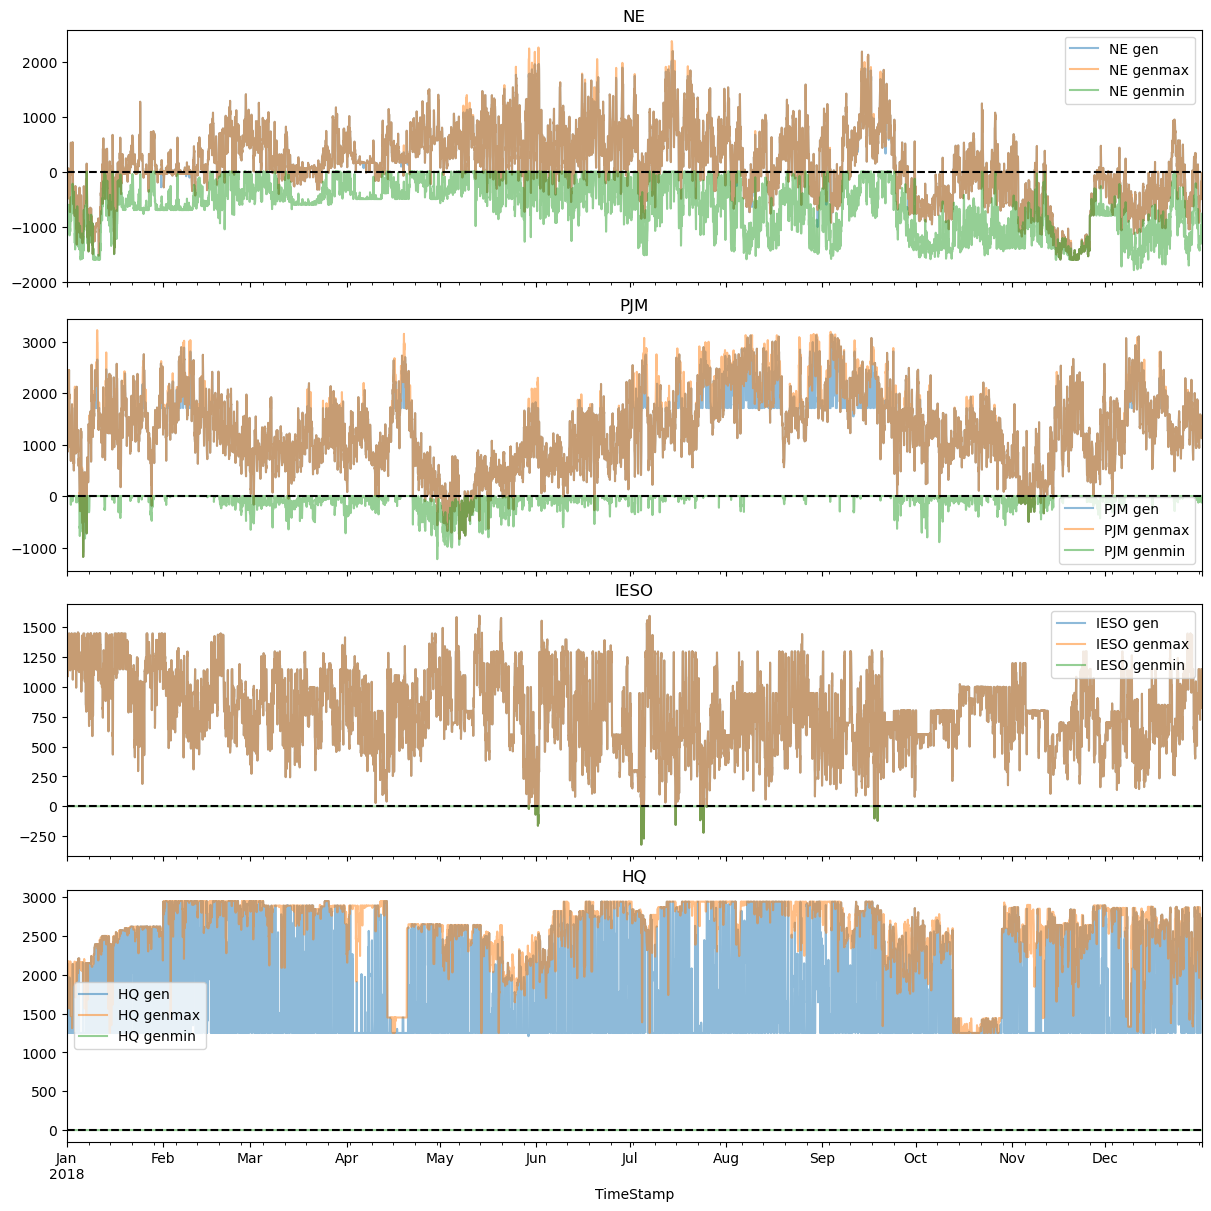

In [35]:
fig, axs = plt.subplots(4, 1, figsize=(
    12, 12), layout='constrained', sharex=True)

pg_ne_sum.plot(ax=axs[0], label='NE gen', alpha=0.5)
genmax_ne_sum.plot(ax=axs[0], label='NE genmax', alpha=0.5)
genmin_ne_sum.plot(ax=axs[0], label='NE genmin', alpha=0.5)
axs[0].set_title('NE')

pg_pjm_sum.plot(ax=axs[1], label='PJM gen', alpha=0.5)
genmax_pjm_sum.plot(ax=axs[1], label='PJM genmax', alpha=0.5)
genmin_pjm_sum.plot(ax=axs[1], label='PJM genmin', alpha=0.5)
axs[1].set_title('PJM')

pg_ieso_sum.plot(ax=axs[2], label='IESO gen', alpha=0.5)
genmax_ieso_sum.plot(ax=axs[2], label='IESO genmax', alpha=0.5)
genmin_ieso_sum.plot(ax=axs[2], label='IESO genmin', alpha=0.5)
axs[2].set_title('IESO')

pg_hq_sum.plot(ax=axs[3], label='HQ gen', alpha=0.5)
genmax_hq_sum.plot(ax=axs[3], label='HQ genmax', alpha=0.5)
genmin_hq_sum.plot(ax=axs[3], label='HQ genmin', alpha=0.5)
axs[3].set_title('HQ')

# pg_external_sum.plot(ax=axs[3], label='External gen', alpha=0.5)
# genmax_profile_external_sum.plot(ax=axs[3], label='External genmax', alpha=0.5)
# genmin_profile_external_sum.plot(ax=axs[3], label='External genmin', alpha=0.5)
# axs[3].set_title('External')

for ax in axs:
    ax.legend()
    ax.axhline(0, color='k', linestyle='--')

plt.show()

### 4. Load shedding

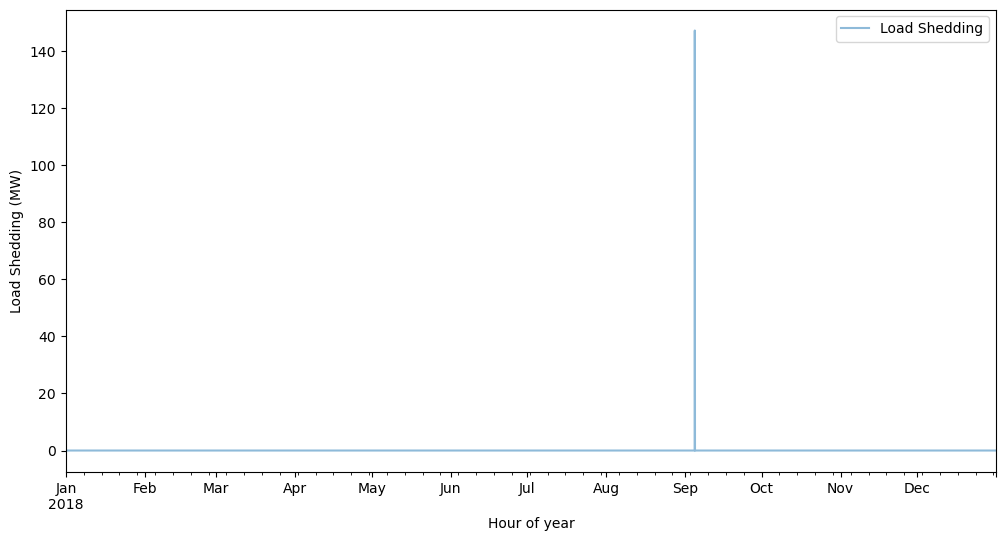

In [36]:
load_shed = pd.Series(slack_results_2030['s_load_shed'], 
                      index=pg_by_fuel_dict_2030['CC_NG'].index)

fig, ax = plt.subplots(figsize=(12, 6))
load_shed.plot(ax=ax, label='Load Shedding', alpha=0.5)
ax.set_xlabel('Hour of year')
ax.set_ylabel('Load Shedding (MW)')
ax.legend()
plt.show()

### 5. Interface flow

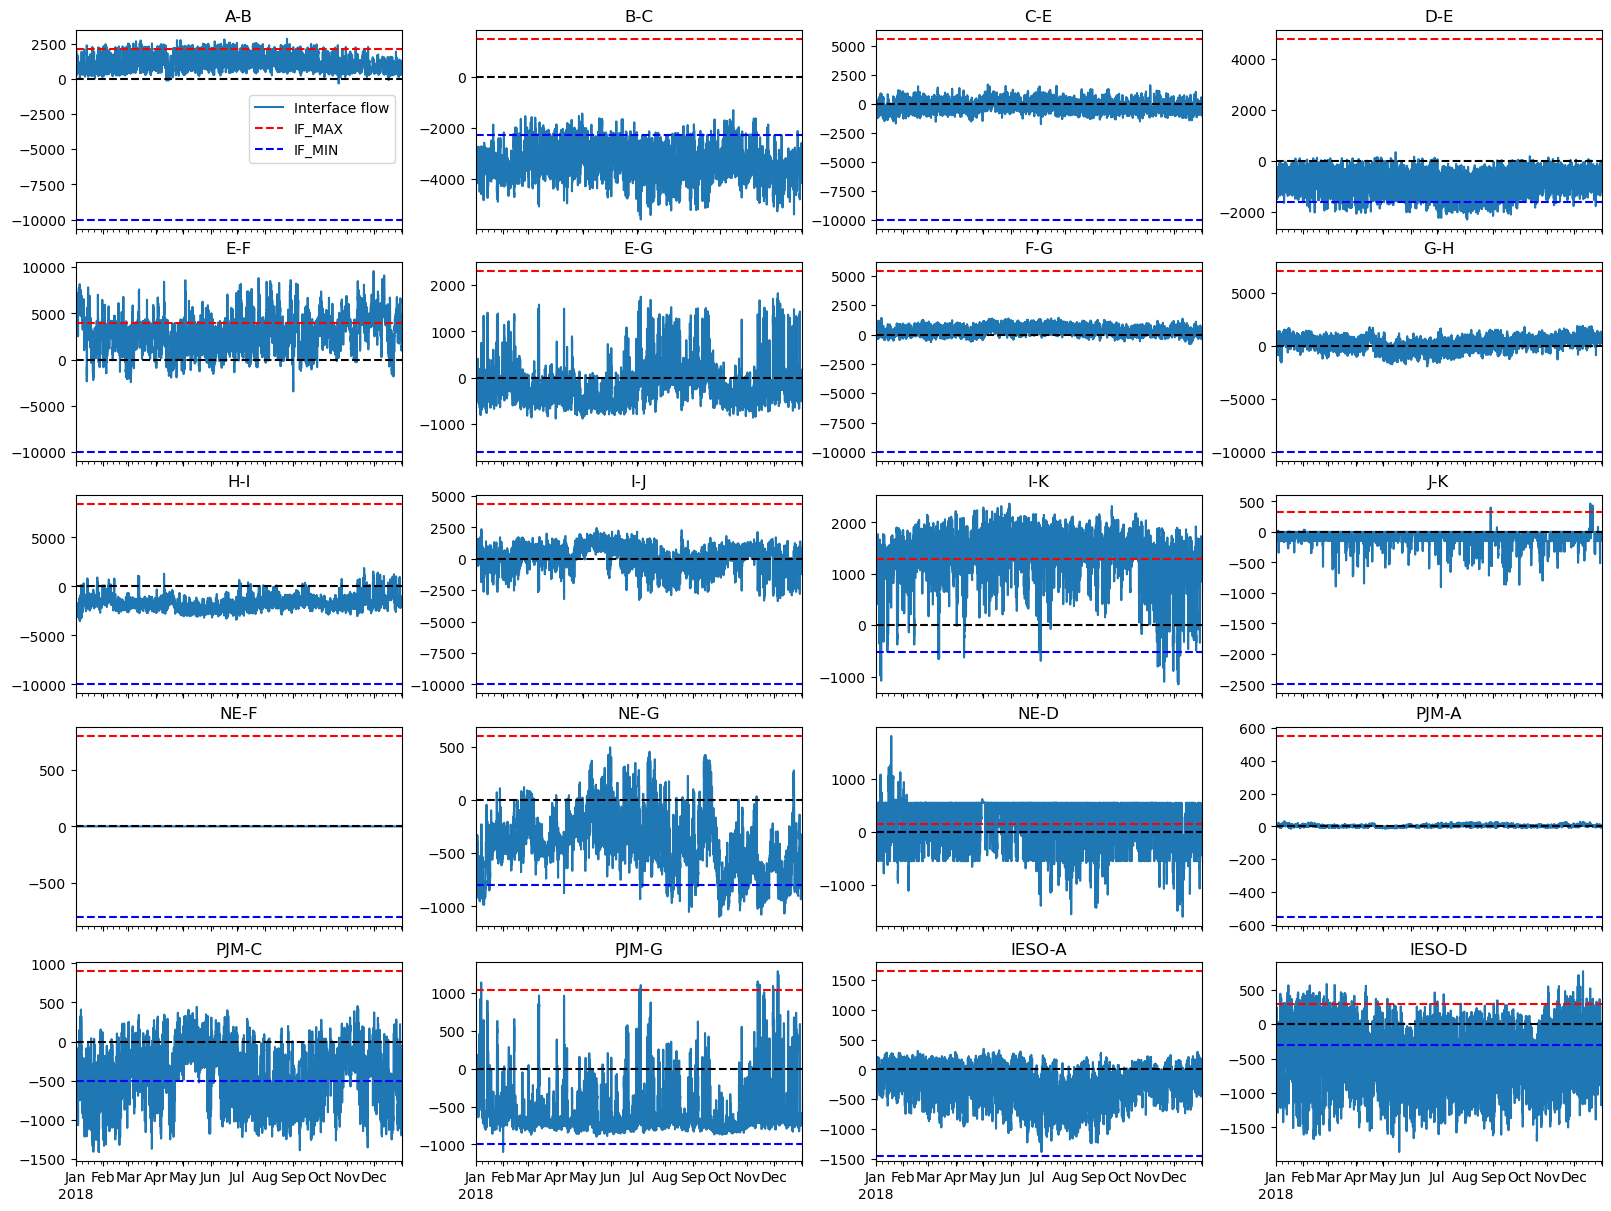

In [37]:
if_lim_prop = grid_prop_2030['if_lim_prop'].copy()
if_lim_prop['Name'] = if_lim_prop.apply(lambda x: f'{x["FROM_ZONE"]}-{x["TO_ZONE"]}', axis=1)

fig, axs = plt.subplots(5, 4, figsize=(16, 12), layout='constrained', sharex=True)

for i, row in if_lim_prop.iterrows():
    name = row['Name']
    if_max = row['IF_MAX']
    if_min = row['IF_MIN']
    if_flow = flow_results_2030['InterfaceFlow'][name]

    ax = axs.flatten()[i]
    if_flow.plot(ax=ax, label='Interface flow')
    ax.axhline(if_max, color='r', linestyle='--', label='IF_MAX')
    ax.axhline(if_min, color='b', linestyle='--', label='IF_MIN')
    ax.axhline(0, color='k', linestyle='--')
    if i == 0:
        ax.legend()
    ax.set_title(name)

plt.show()

<Axes: >

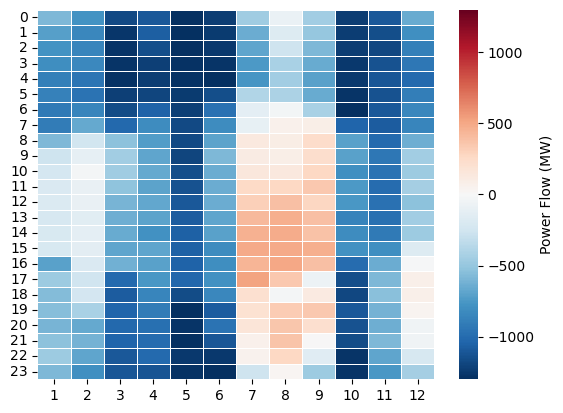

In [38]:
cpny_flow = pg_by_fuel_dict_2030['DCLine_T']['CPNY']
cpny_flow_by_month_hour = cpny_flow.groupby([cpny_flow.index.month, cpny_flow.index.hour]).mean()
cpny_flow_by_month_hour = cpny_flow_by_month_hour.unstack(level=0)

sns.heatmap(cpny_flow_by_month_hour, cmap='RdBu_r', center=0,
            vmax=1300, vmin=-1300,
            linewidths=0.5, linecolor='white', 
            cbar_kws={'label': 'Power Flow (MW)'})


### 6. LMP

In [39]:
# fig, axs = plt.subplots(7, 2, figsize=(12, 12), 
#                         sharex='all', sharey='all')

# for i, ax in enumerate(axs.flat):
#     lmp_results_2018['LMP_by_zone'].iloc[:, i].plot(ax=ax, label='2018 Baseline', alpha=0.5)
#     lmp_results_2030['LMP_by_zone'].iloc[:, i].plot(ax=ax, label='2030 CLCPA', alpha=0.5)
#     ax.set_title(lmp_results_2018['LMP_by_zone'].columns[i])
#     ax.legend()

# fig.tight_layout()

In [40]:
# fig, axs = plt.subplots(2, 2, figsize=(12, 8),
#                         sharex=False, sharey=True)

# for i in range(4):
#     ax = axs.flatten()[i]
    
#     ax.plot(lmp_results_2018['LMP_by_zone'].mean(axis=1).loc[week_list[i][0]:week_list[i][1]], 
#             alpha=0.5, label='2018 Baseline')
#     ax.plot(lmp_results_2030['LMP_by_zone'].mean(axis=1).loc[week_list[i][0]:week_list[i][1]], 
#             alpha=0.5, label='2030 CLCPA')

#     # Formatting
#     ax.xaxis.set_major_formatter(mdates.DateFormatter(r'%m/%d'))
#     # ax.set_ylim(0, 30)
#     ax.tick_params(axis='x', rotation=30)
#     ax.set_title(season_list[i], fontsize=20)
#     ax.grid(axis='x', linestyle='--')
#     ax.tick_params(axis='both', which='major', labelsize=20)
#     if i == 1:
#             ax.legend(fontsize=16, loc='upper right')


# fig.supxlabel('Time', fontsize=20)
# fig.supylabel('LMP ($/MWh)', fontsize=20)
# # title = 'Total thermal generation in NYS'
# # fig.suptitle(title, fontsize=24)
# plt.tight_layout()
# # fig.savefig(os.path.join(fig_dir, f'total_thermal_gen_rep_weeks.png'), 
# #             dpi=600, bbox_inches='tight', format='png')
# # fig.savefig(os.path.join(fig_dir, f'total_thermal_gen_rep_weeks.svg'), 
# #             bbox_inches='tight', format='svg')